# Clasificación

Este código se encarga de leer los registros previamente procesados y generar los datos a predecir para cada registro, basándose en las actividades realizadas por los pacientes en el momento de cada registro EEG. Se ha tomado una muestra del conjunto total de datos para avanzar, ya que el procesamiento completo resultaría demasiado costoso.

In [1]:
import json
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.constraints import max_norm
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import traceback
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Cargamos los registros

In [2]:
# Lista para almacenar los datos de todos los archivos
data = []

try:
    # Obtener la lista de archivos en la carpeta preprocessed
    carpeta_processed = '../Data/Processed/'
    archivos_processed = os.listdir(carpeta_processed)
    
    # Iterar sobre cada archivo
    for archivo in tqdm(archivos_processed, desc="Procesando archivos"):
        # Construir la ruta completa del archivo
        ruta_archivo = os.path.join(carpeta_processed, archivo)
        
        # Leer el contenido del archivo JSON
        with open(ruta_archivo, 'r') as f:
            datos_archivo = json.load(f)
        
        # Agregar los datos del archivo a la lista de datos totales
        data.append(datos_archivo)
        
    print(f"Datos cargados exitosamente desde la carpeta processed.")
    
except Exception as e:
    print(f"Error al cargar los datos desde {ruta_archivo}.")
    traceback.print_exc()

Procesando archivos: 100%|██████████████████████████████████████████████████████████████████| 240/240 [01:17<00:00,  3.11it/s]

Datos cargados exitosamente desde la carpeta processed.


## Preparación de datos

Para preparar nuestros datos, primero debemos estructurarlos en secuencias que representen las diversas actividades realizadas durante las sesiones de EEG. Cada paciente sigue un protocolo predefinido, ejecutando una serie de tareas en un orden específico que abarca desde la línea de base hasta acciones motoras e imaginadas. Este orden se presenta de la siguiente manera:

1. Baseline, eyes open
2. Baseline, eyes closed
3. Task 1 (open and close left or right fist)
4. Task 2 (imagine opening and closing left or right fist)
5. Task 3 (open and close both fists or both feet)
6. Task 4 (imagine opening and closing both fists or both feet)
7. Task 1
8. Task 2
9. Task 3
10. Task 4
11. Task 1
12. Task 2
13. Task 3
14. Task 4

In [3]:
def generar_secuencia(x):
    secuencia = [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
    pacientes = x// 12
    res = []
    for e in range(pacientes):
        res.extend(secuencia)
    return res

In [4]:
data_clasificacion = generar_secuencia(len(data))
print(data_clasificacion)
print(f"Total registros: {len(data_clasificacion)}")
print(f"Total registros: {len(data)}")
print(f"Total de registros por canal: {len(data[0][0])}")

[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
Total registros: 240
Total registros: 240
Total de registros por canal: 9600


Ejemplo de datos para prueba:

In [5]:
eeg_data_prueba = [
    [[47, 69, 12, 85, 52],[38, 19, 94, 25, 10]],
    [[85, 60, 17, 89, 28],[18, 17, 77, 83, 23]],
    [[79, 5, 38, 97, 26],[7, 53, 70, 82, 44]],
    [[73, 86, 99, 54, 7],[66, 42, 65, 63, 56]],
    [[20, 92, 78, 82, 63],[97, 8, 51, 13, 19]],
    [[51, 99, 24, 67, 97],[13, 40, 4, 36, 41]],
    [[28, 62, 57, 54, 100],[31, 81, 52, 46, 31]],
    [[26, 65, 16, 78, 51],[65, 44, 41, 41, 70]],
    [[97, 77, 93, 30, 61],[23, 85, 79, 60, 44]],
    [[90, 28, 14, 15, 99],[97, 26, 30, 53, 92]],
]
actividades_prueba = [0, 1, 2, 3, 0, 1, 2, 3, 0]


### Convertimos los datos de float 64 bits a float 32 bits.

In [6]:
# Convertir a numpy arrays
#eeg_data = np.array(data).astype(np.float32)
eeg_data = np.array(data, dtype=np.float32)

In [7]:
actividades = np.array(data_clasificacion)

In [8]:
# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(eeg_data, actividades, test_size=0.2, random_state=42)

## Creamos el modelo CNN

## Modelo TCN

Se define un modelo CNN para la clasificación de las actividades EEG. La arquitectura incluye varias capas convolucionales (Conv1D), capas de pooling (MaxPooling1D), y capas densas. Se utilizan técnicas como la normalización por lotes (BatchNormalization) y el dropout para evitar el sobreajuste.

In [9]:
y_train_one_hot = to_categorical(y_train, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)

## Modelo 

In [10]:
model_CNN = tf.keras.Sequential([
    Dropout(0.90, input_shape=(len(eeg_data[0]), len(eeg_data[0][0]))),
    Conv1D(128, 4),
    Conv1D(128, 4),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling1D(2),
    Dropout(0.90),
    Conv1D(128, 10),
    Conv1D(128, 10),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling1D(10),
    Flatten(),
    Dropout(0.90),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

C:\Users\Fernando\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\regularization\dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Compilar el modelo
model_CNN.compile(
    loss="categorical_crossentropy",  # Cambiado a categorical_crossentropy para clasificación multiclase
    optimizer=Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [13]:
start_time = time.time()

history = model_CNN.fit(X_train, y_train_one_hot, epochs=2, validation_data=(X_test, y_test_one_hot), verbose=1)

end_time = time.time()

elapsed_time = end_time - start_time

# Obtener las accuracies finales
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Tiempo de entrenamiento: {elapsed_time} segundos")
print(f"Accuracy final en entrenamiento: {final_train_accuracy}")
print(f"Accuracy final en validación: {final_val_accuracy}")

Epoch 1/2
6/6 ━━━━━━━━━━━━━━━━━━━━ 109s 19s/step - accuracy: 0.2954 - loss: 3.5277 - val_accuracy: 0.1875 - val_loss: 3.5136
Epoch 2/2
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3097 - loss: 3.5171 - val_accuracy: 0.2292 - val_loss: 3.4983
Tiempo de entrenamiento: 121.96238875389099 segundos
Accuracy final en entrenamiento: 0.2760416567325592
Accuracy final en validación: 0.2291666716337204


In [14]:
model_CNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_3 (Dropout)                  │ (None, 64, 9600)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 64, 256)             │       9,830,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 64, 256)             │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 64, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 32, 256)             │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 32, 256)             │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 3, 128)              │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 35,282,254 (134.59 MB)

 Trainable params: 11,760,068 (44.86 MB)

 Non-trainable params: 2,048 (8.00 KB)

 Optimizer params: 23,520,138 (89.72 MB)

In [15]:
#Guadamos el modelo
model_CNN.save('../Data/Models/modelo_CNN.h5')
#Guardamos el historial de entrenamiento
history_filename = '../Data/Models/history.pkl'

# Guardar history usando pickle
with open(history_filename, 'wb') as file:
    pickle.dump(history, file)

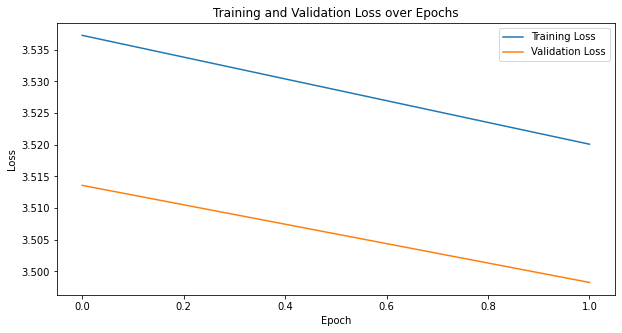

In [16]:
# Obtener la pérdida y la precisión en entrenamiento y validación
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Visualizar la curva de pérdida
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

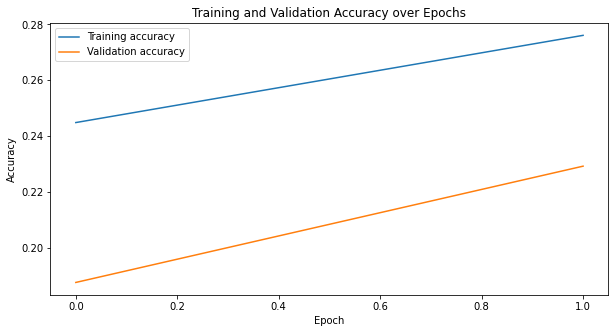

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.2257 - loss: 3.4975
Accuracy on test data: 0.2291666716337204


In [17]:
# Obtener la precisión en entrenamiento y validación
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Visualizar la curva de precisión
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Calcular la precisión final en el conjunto de prueba
test_loss, test_accuracy = model_CNN.evaluate(X_test, y_test_one_hot)
print("Accuracy on test data:", test_accuracy)


In [21]:
predictions = model_CNN.predict(X_test)

predicted_classes = np.argmax(predictions, axis=1)

accuracy_by_task = []
loss_by_task = []

# Iterar sobre cada tarea
for task_index in range(4): 
    task_indices = np.where(np.argmax(y_test_one_hot, axis=1) == task_index)[0]
    
    task_accuracy = np.mean(predicted_classes[task_indices] == task_index)
    accuracy_by_task.append(task_accuracy)

    task_loss = model_CNN.evaluate(X_test[task_indices], y_test_one_hot[task_indices], verbose=0)[0]
    loss_by_task.append(task_loss)

average_accuracy = np.mean(accuracy_by_task)

results_df = pd.DataFrame({
    'Task': ['Task 1', 'Task 2', 'Task 3', 'Task 4'],
    'Accuracy': accuracy_by_task,
    'Loss': loss_by_task
})

total_accuracy = np.mean(accuracy_by_task)
total_loss = np.mean(loss_by_task)

results_df.loc[len(results_df)] = ['Total', total_accuracy, total_loss]

print("Accuracy and Loss per Task:")
print(results_df)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Accuracy and Loss per Task:
     Task  Accuracy      Loss
0  Task 1  0.083333  3.500122
1  Task 2  0.000000  3.511108
2  Task 3  0.250000  3.496927
3  Task 4  0.777778  3.476100
4   Total  0.277778  3.496064


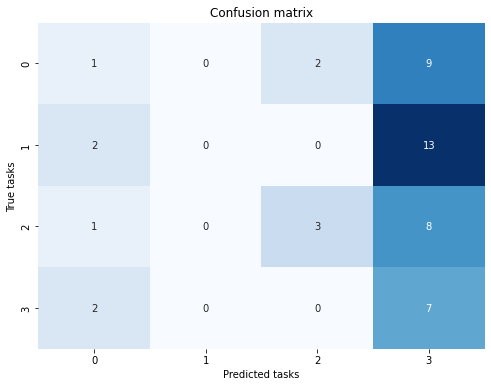

In [23]:
conf_matrix = confusion_matrix(np.argmax(y_test_one_hot, axis=1), predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted tasks')
plt.ylabel('True tasks')
plt.title('Confusion matrix')
plt.show()
